# Приоритизация гипотез и анализ A/B-теста

**Цель проекта** — приоритизация гипотез, запуск A/B-теста и анализ результатов с целью увеличения выручки интернет-магазина.

**Ход исследования**

Входные данные:

 - датасет с девятью гипотезами по увеличению выручки интернет-магазина;
 - данные о заказах;
 - данные о количестве пользователей в указанную дату в указанной группе A/B-теста.

Исследование пройдёт в четыре этапа:

 1. Обзор данных.
 2. Предобработка данных.
 3. Приоритизация гипотез.
 4. Анализ A/B-теста.

<a id="start1"></a>
### Start

## Обзор данных

In [1]:
# импорт библиотек
import pandas as pd
import datetime as dt
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

In [2]:
try: # Локальный путь
    hypothesis, orders, visitors = (
    pd.read_csv('hypothesis.csv'), 
    pd.read_csv('orders.csv'),  
    pd.read_csv('visitors.csv')    
)
except:
    hypothesis, orders, visitors = (
    pd.read_csv('/datasets/hypothesis.csv'),  
    pd.read_csv('/datasets/orders.csv'),    
    pd.read_csv('/datasets/visitors.csv')    
)
# отражение содержимого ячейки полностью
pd.set_option('display.max_colwidth', 120)
    
# 2 знака после точки для формата float    
pd.options.display.float_format ='{:,.2f}'.format 

Выведу на экран таблицу `hypothesis` и первые пять строк из остальных таблиц:

In [3]:
hypothesis.head(9)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [4]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [5]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Получу общую информацию о всех таблицах:

In [6]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


В таблице **`hypothesis`** пять столбцов. В столбцах два типа данных — `int64` и `object`.

Согласно документации к данным:

- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Все колонки не соответствуют стилю написания названий колонок.   

In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


В таблице **`orders`** пять столбцов. В столбцах два типа данных — `int64` и `object` .

Согласно документации к данным:

- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.


Две колонки не соответствуют стилю написания названий колонок. Необходимо привести тип данных столбца date к формату даты, сделаю это в п.4.1.

In [8]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


В таблице **`visitors`** три столбца. В столбцах  два типа данных — `object` и `int64`. Необходимо привести тип данных столбца date к формату даты, сделаю это в п.4.1.

Согласно документации к данным:

- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

**Выводы**

В таблице `hypothesis` содержится 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort. В двух других - результаты A/B-теста.

Названия колонок в таблицах `hypothesis` и `orders` не соответствуют стилю написания названий колонок.

Для дальнейшей работы необходимо изменить написание названий столбцов, проверить данные на наличие дубликатов и пропусков.

## Предобработка данных

### Переименование столбцов

Для удобства выведу названия столбцов таблиц на экран.

In [9]:
# вывод названия столбцов  
hypothesis.columns

Index(['Hypothesis', 'Reach', 'Impact', 'Confidence', 'Efforts'], dtype='object')

In [10]:
# вывод названия столбцов
orders.columns

Index(['transactionId', 'visitorId', 'date', 'revenue', 'group'], dtype='object')

Приведу названия столбцов таблиц к общепринятому стилю. 

In [11]:
# изменение названий столбцов 
hypothesis.columns = hypothesis.columns.str.lower()
orders.columns = ['transaction_id', 'visitor_id', 'date', 'revenue', 'group']

Проверю результат.

In [12]:
hypothesis.head()

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


In [13]:
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


### Дубликаты

Проверю наличие дубликатов во всех таблицах.

In [14]:
orders.duplicated().sum()

0

In [15]:
visitors.duplicated().sum()

0

### Пропуски

Проверю наличие пропусков в таблицах `orders` и `visitors`.

In [16]:
round((orders.isna().mean()*100))

transaction_id   0.00
visitor_id       0.00
date             0.00
revenue          0.00
group            0.00
dtype: float64

In [17]:
round((visitors.isna().mean()*100))

date       0.00
group      0.00
visitors   0.00
dtype: float64

### Проверка на одновременное участие пользователя в двух группах

Проверю наличие пользователей, одновременно участвующих и в группе А, и в группе В.

In [18]:
orders.groupby('visitor_id').agg({'group':'nunique'}).query('group>1').shape[0]

58

Проверю, сколько всего было пользователей в исследуемый период.

In [19]:
orders['visitor_id'].nunique()

1031

Получается, что 5.6% пользователей (58 из 1031) относились и к группе А, и в группе В. Если от них избавиться, то в каждой исследуемой группе мы потеряем более 10% данных. Это существенные доли, удаление которых может повлиять на результат А/В теста. Поэтому не буду их трогать.

**Выводы**

- Изменены названия столбцов в двух таблицах в соответствии с общепринятых стилем написания, 
- дубликатов данных в таблицах не обнаружено, 
- пропусков не обнаружено,
- обаружено 58 пользователей, участвующих в обоих группах теста. Принято решение их оставить.

[в начало](#start1)

##  Приоритизация гипотез

### ICE

Примению фреймворк ICE для приоритизации гипотез и отсортирую их по убыванию приоритета.

In [20]:
hypothesis['ICE'] = hypothesis['impact'] * hypothesis['confidence']/hypothesis['efforts']

hypothesis[['hypothesis', 'ICE']].sort_values(by = 'ICE', ascending=False)


,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


 В первой пятерке гипотезы: 8, 0, 7, 6 и 2

### RICE

Примению фреймворк RICE для приоритизации гипотез и отсортирую их по убыванию приоритета.

In [21]:
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] \
* hypothesis['confidence']/hypothesis['efforts']

hypothesis[['hypothesis', 'RICE']].sort_values(by = 'RICE', ascending=False)


,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.00
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.00
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.00


В первой пятерке те же гипотезы, но уже в другой последовательности: 7, 2, 0, 6 и 8. 

**Выводы**

Применены фреймворки ICE и RICE для приоритизации гипотез.  

В первой пятерке фреймворка ICE гипотезы расположились в следующей последовательности по убыванию: 8, 0, 7, 6 и 2.  
В первой пятерке фреймворка RICE те же перспективные гипотезы: 7, 2, 0, 6 и 8, но уже в другой последовательности.

Изменение в приоритизации гипотез произошло по причине использования во фреймворке RICE параметра охвата пользователей - reach.
На первом месте фреймворка RICE гипотеза 7, т.к. ее параметр Reach равен 10ти. На втором - гипотеза 2 с параметром Reach, равном 8ми. Гипотеза 8 опустилась на 5е место, т.к. ее параметр Reach равен 1.

[в начало](#start1)

## Анализ A/B-теста

###  График кумулятивной выручки по группам

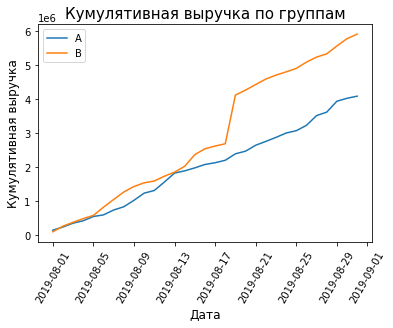

In [22]:
# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()

orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

datesGroups = orders[['date', 'group']].drop_duplicates()

ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.legend()

plt.title('Кумулятивная выручка по группам', fontsize=15)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Кумулятивная выручка',fontsize=12)
plt.xticks(rotation=60) ;


Выручка почти равномерно увеличивается в течение всего теста. 
Однако график выручки группы В в одной точке резко растет. Это может сигнализировать о всплеске числа заказов, либо о появлении очень дорогого/дорогих заказов в выборке. 

### График кумулятивного среднего чека по группам

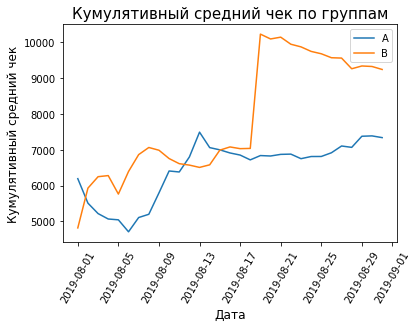

In [23]:
plt.plot(
    cumulativeRevenueA['date'], 
    cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], 
    label='A')
plt.plot(
    cumulativeRevenueB['date'], 
    cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], 
    label='B')
plt.legend()
plt.title('Кумулятивный средний чек по группам', fontsize=15)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Кумулятивный средний чек',fontsize=12)
plt.xticks(rotation=60);

Средний чек становится более равномерным с середины теста для группы A, ближе к концу теста он медленно увеличивается и в последние дни теста чуть идет на спад. Для группы B к самому концу теста он более менее выравнивается, но продолжает снижаться. Вероятнее всего, в группу B все же попал крупный заказ/заказы (резкий всплеск на графике 18 августа). Тогда ей нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне. Для группы А также необходимо больше данных, чтобы более уверенно зафиксировался средний чек.  
Однако четко видно, что по кумулятивному среднему чеку с середины теста уверенно лидирует группа В.

### График относительного изменения кумулятивного среднего чека группы B к группе A

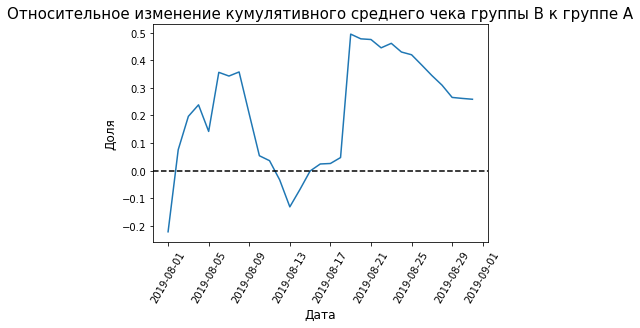

In [24]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.title(
    'Относительное изменение кумулятивного среднего чека группы B к группе A', 
    fontsize=15)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Доля',fontsize=12)
plt.xticks(rotation=60);

В нескольких точках график различия между группами резко «скачет». Причина должна быть в крупных заказах и выбросах.

### График кумулятивной конверсии по группам

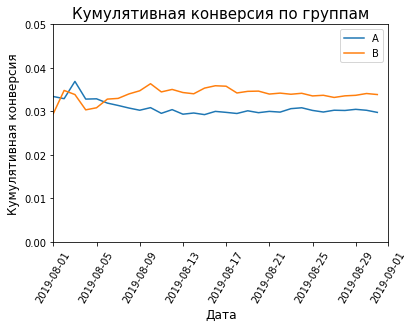

In [25]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

# задаем масштаб осей
plt.axis(["2019-08-01", '2019-09-01', 0, 0.05])

plt.title(
    'Кумулятивная конверсия по группам', 
    fontsize=15)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Кумулятивная конверсия',fontsize=12)
plt.xticks(rotation=60);

В первые дни теста в основном незначительно лидировала конверсия группы А. Затем конверсия группы В вырвалась вперёд и зафиксировалась около одного значения, а конверсия группы А просела и также зафиксировалась.

### График относительного изменения кумулятивной конверсии группы B к группе A

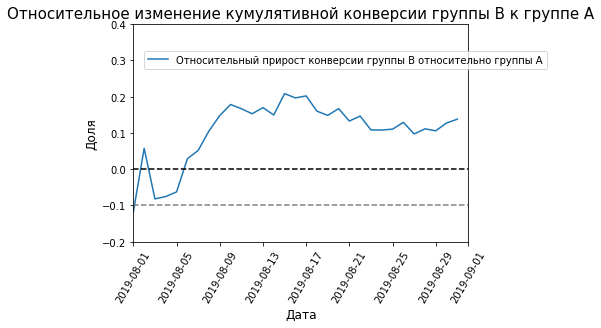

In [26]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(
    cumulativeDataB[['date','conversion']], 
    left_on='date', 
    right_on='date', 
    how='left', 
    suffixes=['A', 'B'])

plt.plot(
    mergedCumulativeConversions['date'], 
    mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, 
    label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-09-01', -0.2, 0.4])

plt.title(
    'Относительное изменение кумулятивной конверсии группы B к группе A', 
    fontsize=15)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Доля',fontsize=12)
plt.xticks(rotation=60)
plt.legend(bbox_to_anchor = (1, 0.65, 0.25, 0.25));

В начале теста группа B проигрывала группе A (за исключением одного дня), затем вырвалась вперёд. В середине теста разница в конверсиях групп доходила до 20%, во второй половине теста опустилась до уровня около 10% и в целом зафиксировалась.

### Точечный график количества заказов по пользователям

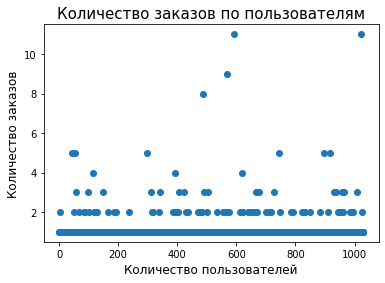

In [27]:
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
ordersByUsers.describe()
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['transaction_id']) 

plt.title(
    'Количество заказов по пользователям', 
    fontsize=15)
plt.xlabel('Количество пользователей', fontsize=12)
plt.ylabel('Количество заказов',fontsize=12);

Основная часть пользователей совершала один заказ, реже делалось 2 заказа. Однако встречались единичные пользователи с количеством заказов от 8 до 11. 

### 95-й и 99-й перцентили количества заказов на пользователя

In [28]:
np.percentile(ordersByUsers['transaction_id'], [95, 99])

array([2., 4.])

Не более 5% пользователей оформляли больше, чем 2 заказа. И 1% пользователей заказывали более 4х раз.
Разумно выбрать 2 заказа на одного пользователя за нижнюю границу числа заказов, и отсеять аномальных пользователей по ней.

###  Точечный график стоимостей заказов

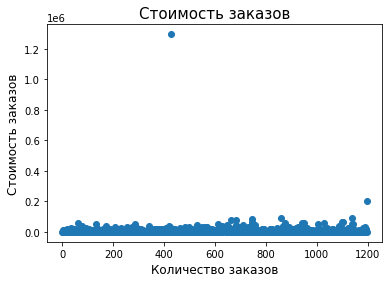

In [29]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title(
    'Стоимость заказов', 
    fontsize=15)
plt.xlabel('Количество заказов', fontsize=12)
plt.ylabel('Стоимость заказов',fontsize=12);

Практически все стоимости заказов находятся в пределах порядка 50 тыс. Однако есть один заказ суммой около 200тыс.руб. и еще один с суммой более 1.2 млн. 

Для более детального изучения приближу график.

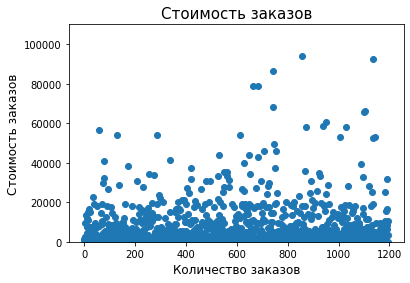

In [30]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title(
    'Стоимость заказов', 
    fontsize=15)
plt.xlabel('Количество заказов', fontsize=12)
plt.ylabel('Стоимость заказов',fontsize=12)
plt.ylim((0,110000));

Здесь основные стоимости заказов наблюдаются в районе 20 тыс.

### 95-й и 99-й перцентили стоимости заказов

In [31]:
print(np.percentile(orders['revenue'], [95, 99])) 

[28000.  58233.2]


Не более 5% заказов дороже 28000 рублей и не более 1% дороже 58233.2 рублей.

### Статистическая значимость различий в конверсии между группами по «сырым» данным

Посчитаю статистическую значимость различий в конверсии между группами по «сырым» данным — без удаления аномальных пользователей.
Сформулирую гипотезы.   
Нулевая: различий в конверсии между группами нет.  
Альтернативная: различия в конверсии между группами есть.

In [32]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders']

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

results_conv = stats.mannwhitneyu(sampleA, sampleB)[1]

print("{0:.3f}".format(results_conv))

print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

# сравнение p-значения со значением alpha
alpha = .05
if (results_conv < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

0.017
0.138
Отвергаем нулевую гипотезу


P-value меньше 0.05, поэтому нулевую гипотезу отвергаю. Анализ "сырых" данных сообщает, что в конверсии между группами есть статистически значимые различия.
Относительный прирост конверсии группы В к конверсии группы А равен 13.8% 

### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Посчитаю статистическую значимость различий в среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей.
Сформулирую гипотезы.   
Нулевая: различий в среднем чеке между группами нет.  
Альтернативная: различия в среднем чеке между группами есть.

In [33]:
results_receipt = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]

print('{0:.3f}'.format(results_receipt))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

# сравнение p-значения со значением alpha
alpha = .05
if (results_receipt < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

0.729
0.259
Не получилось отвергнуть нулевую гипотезу


P-value значительно больше 0.05 - статистически значимых отличий в среднем чеке между группами нет, нулевая гипотеза подтверждена.  Несмотря на то, что относительное различие среднего чека между сегментами 25.9%

### Статистическая значимость различий в конверсии между группами по «очищенным» данным

Посчитаю статистическую значимость различий в конверсии между группами по «очищенным» данным — с удалением аномальных пользователей.
Сформулирую гипотезы.   
Нулевая: различий в конверсии между группами нет.  
Альтернативная: различия в конверсии между группами есть.

In [34]:
usersWithManyOrders = pd.concat(
    [
        #ordersByUsersA[ordersByUsersA['orders'] > 2]['visitor_id'],
        #ordersByUsersB[ordersByUsersB['orders'] > 2]['visitor_id'],
        
        ordersByUsersA[ordersByUsersA['orders'] > np.percentile(ordersByUsers['transaction_id'], 95)]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] > np.percentile(ordersByUsers['transaction_id'], 95)]['visitor_id'],               
    ],
    axis=0,
)
#usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitor_id']

usersWithExpensiveOrders = orders[orders['revenue'] > np.percentile(
    orders['revenue'], 95)]['visitor_id']                       
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

results_conv_ = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]
print("{0:.3f}".format(results_conv_))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))


# сравнение p-значения со значением alpha
alpha = .05
if (results_conv < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

0.013
0.173
Отвергаем нулевую гипотезу


Как и в случае с "сырыми" данными статистическая значимость различия конверсий между группами достигнута. Нулевая гипотеза отвернута. Сегмент В значительно лучше сегмента А.

### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

Посчитаю статистическую значимость различий в среднем чеке между группами по «очищенным» данным — с удалением аномальных пользователей.
Сформулирую гипотезы.   
Нулевая: различий в среднем чеке между группами нет.  
Альтернативная: различия в среднем чеке между группами есть.

In [35]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(orders[np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

0.738


In [36]:

results_receipt_ = stats.mannwhitneyu(orders[np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],)[1]
    
        


print('{0:.3f}'.format(results_receipt_))
print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

# сравнение p-значения со значением alpha
alpha = .05
if (results_receipt_ < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

0.738
-0.020
Не получилось отвергнуть нулевую гипотезу


P-value по-прежнему значительно больше 0.05 - статистически значимых отличий в среднем чеке между группами нет, нулевая гипотеза подтверждена.  А вот относительный прирост среднего чека группы В к конверсии группы А равен минус 2%, т.е. в очищенных данных относительный прирост среднего чека группы А чуть выше группы В.

**Выводы**

- Выручка почти равномерно увеличивается в течение всего теста. График выручки группы В в одной точке резко растет,
- Средний чек становится более равномерным с середины теста для группы A, ближе к концу теста он медленно увеличивается и в последние дни теста чуть идет на спад. Для группы B к самому концу теста он более менее выравнивается, но продолжает снижаться. По кумулятивному среднему чеку с середины теста уверенно лидирует группа В.
- В нескольких точках график различия в среднем чеке между группами резко «скачет». 
- В первые дни теста в основном незначительно лидировала конверсия группы А. Затем конверсия группы В вырвалась вперёд и зафиксировалась около одного значения, конверсия группы А просела и также зафиксировалась.
- В начале теста группа B проигрывала группе A (за исключением одного дня) в относительном приросте конверсии, затем вырвалась вперёд. В середине теста разница в консерсиях групп доходила до 20%, во второй половине теста опустилась до уровня около 10% и в целом зафиксировалась.
- Основная часть пользователей совершала один заказ, реже делалось 2 заказа. Однако встречались единичные пользователи с количеством заказов от 8 до 11.
- Не более 5% пользователей оформляли больше, чем 2 заказа. И 1% пользователей заказывали более 4х раз.
- Практически все стоимости заказов находятся в пределах порядка 50 тыс. Однако есть один заказ суммой около 200тыс.руб. и еще один с суммой более 1.2 млн.
- Не более 5% заказов дороже 28000 рублей и не более 1% дороже 58233.2 рублей.
- Отвергнута нулевая гипотеза о том, что различий в конверсии между группами нет. Анализ "сырых" данных сообщает, что в конверсии между группами есть статистически значимые различия. Относительный прирост конверсии группы В к конверсии группы А равен 13.8%
- Подтверждена нулевая гипотеза о том, что различий в среднем чеке между группами нет.Относительное различие среднего чека между сегментами 25.9%
- Статистическая значимость различия конверсий между группами в "очищенных" данных достигнута. Нулевая гипотеза отвернута. Сегмент В значительно лучше сегмента А.
- Статистически значимых отличий в среднем чеке между группами в "очищенных" данных нет, нулевая гипотеза подтверждена. Относительный прирост среднего чека группы В к конверсии группы А равен минус 2%, т.е. в "очищенных" данных относительный прирост среднего чека группы А чуть выше группы В.

[в начало](#start1)

## Выводы

- Есть статистически значимое различие по конверсии между группами в пользу группы В как по сырым данным, так и после фильтрации аномалий 

- Как по "сырым", так и по "очищенным" данным нет статистически значимого различия по среднему чеку между группами. В "очищенных" данных относительный прирост среднего чека группы А чуть выше группы В.

- График различия конверсии между группами сообщает, что результаты группы B лучше группы A и значительно выше среднего значения.

- График различия среднего чека колеблется. Во второй половине теста результаты группы B намного лучше группы A, но наблюдается тенденция к снижению различия среднего чека. Сделать из этого графика определённые выводы нельзя.

Исходя из перечисленных фактов предлагается завершить тест с объявлением победителем группу В.

[в начало](#start1)